<a href="https://colab.research.google.com/github/Amaljayaranga/Constrastive-Loss-Experiments/blob/master/Constrastive_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result eithe

Epoch :  1 Batch :  0 loss :  0.3631872534751892
Epoch :  1 Batch :  100 loss :  0.23724937438964844
Epoch :  1 Batch :  200 loss :  0.23413529992103577
Epoch :  1 Batch :  300 loss :  0.20855647325515747
Epoch :  1 Batch :  400 loss :  0.21578127145767212
Epoch :  1 Batch :  500 loss :  0.20471371710300446
Epoch :  1 Batch :  600 loss :  0.2104533463716507
Epoch :  1 Batch :  700 loss :  0.20388659834861755
Epoch 1 loss  0.21869845763842266


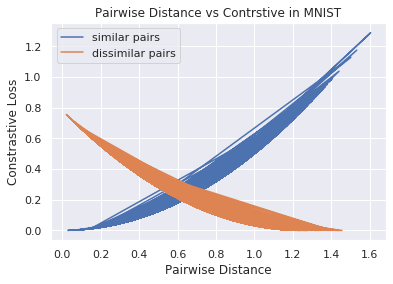

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

Epoch :  2 Batch :  0 loss :  0.2308327555656433
Epoch :  2 Batch :  100 loss :  0.204092875123024
Epoch :  2 Batch :  200 loss :  0.2134990394115448
Epoch :  2 Batch :  300 loss :  0.22302989661693573
Epoch :  2 Batch :  400 loss :  0.2226523756980896
Epoch :  2 Batch :  500 loss :  0.23917248845100403
Epoch :  2 Batch :  600 loss :  0.19323989748954773
Epoch :  2 Batch :  700 loss :  0.18730883300304413
Epoch 2 loss  0.2155254534482956


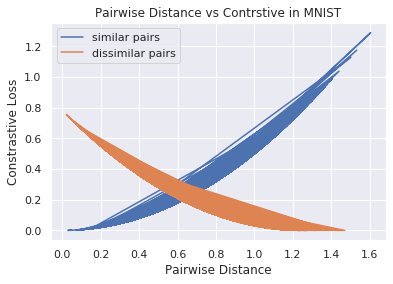

In [3]:
import torch.nn.functional as F
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from argparse import ArgumentParser
import seaborn as sns; sns.set()
from SiamseNet import SimaseNet
from SimaseDataset import SiameseMNIST
import torch.nn  as nn



parser = ArgumentParser(description='Simase Network ')
parser.add_argument('--learning_batch_size', type=int, default=64)
parser.add_argument('--constractive_loss_margin', type=float, default=1.25)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=2)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')


args, unknown = parser.parse_known_args()

pwd_similiar = np.array([])
loss_similar = np.array([])

pwd_dis = np.array([])
loss_dis = np.array([])

class ContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin


    def forward(self, output1, output2, target):
        eq_distance = F.pairwise_distance(output1, output2)
        np_target = target.numpy()
        np_distance = eq_distance.detach().numpy()
        #print(np_distance[[np.where(np_target == 0)]])

        global pwd_similiar, pwd_dis,loss_similar,loss_dis

        pwd_similiar = np.append(pwd_similiar, np_distance[[np.where(np_target == 0)]])
        pwd_dis = np.append(pwd_dis, np_distance[[np.where(np_target == 1)]])

        loss = 0.5 * (1 - target.float()) * torch.pow(eq_distance, 2) + \
               0.5 * target.float() * torch.pow(torch.clamp(self.margin - eq_distance, min=0.00), 2)
        np_loss = loss.detach().numpy()

        loss_similar = np.append(loss_similar, np_loss[[np.where(np_target == 0)]])
        loss_dis = np.append(loss_dis, np_loss[[np.where(np_target == 1)]])

        #print('shape ', ' similar distances', len(pwd_similiar),len(loss_similar))
        #print('shape ', ' dis distances', len(pwd_dis), len(loss_dis))

        return loss.mean()

def draw_plot():
    global pwd_similiar, pwd_dis,loss_similar,loss_dis
    plt.plot(pwd_similiar, loss_similar, label="similar pairs")
    plt.plot(pwd_dis, loss_dis, label="dissimilar pairs")
    plt.xlabel('Pairwise Distance')
    plt.ylabel('Constrastive Loss')
    plt.title('Pairwise Distance vs Contrastive in MNIST')
    plt.legend()
    plt.show()
    pwd_similiar = np.delete(pwd_similiar, [0,pwd_similiar.size-1])
    pwd_dis = np.delete(pwd_dis, [0,pwd_dis.size-1])
    loss_similar = np.delete(loss_similar, [0,loss_similar.size-1])
    loss_dis = np.delete(loss_dis, [0,loss_dis.size-1])

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform = transforms.Compose([
                                 transforms.ToTensor()
                             ]))

test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

siamese_train_dataset = SiameseMNIST(train_dataset)
split = int(np.floor(args.validation_split * len(siamese_train_dataset)))
indices = list(range(len(siamese_train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size = args.learning_batch_size,
                                                   sampler=train_sampler)
siamese_val_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size = args.learning_batch_size,
                                                  sampler=valid_sampler)

simase_test_dataset = SiameseMNIST(test_dataset)
siamese_test_loader = torch.utils.data.DataLoader(simase_test_dataset, batch_size = 1, shuffle=True)


model = SimaseNet()
criterion = ContrastiveLoss(margin=args.constractive_loss_margin)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

train = True

if train:
    # training
    model.train()
    losses = []
    chunk = 100

    for epoch in range(1, args.num_epochs+1):

        for batch_idx, batch in enumerate(siamese_train_loader):

            img1, img2, target = batch

            optimizer.zero_grad()
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, target)
            loss.backward()
            optimizer.step()

            if batch_idx % chunk == 0:
              print("Epoch : ", epoch, "Batch : " , batch_idx, "loss : ", loss.item())
            losses.append(loss.item())

        print("Epoch", epoch, "loss ", np.mean(losses))
        draw_plot()

    torch.save(model, 'simase.pth')

if not train:

        model = torch.load('simase.pth')
        model.eval()

        lss = []
        lds = []

        for batch_idx, data in enumerate(siamese_test_loader):
            img1, img2, target = data
            out1, out2 = model(img1, img2)
            eq = F.pairwise_distance(out1,out2)
            print(eq)

            #same =0
            if target == 0 :
                loss = criterion(out1, out2, target)
                print('loss',loss)
                lss.append(loss)
            else:
                loss = criterion(out1, out2, target)
                lds.append(loss)






